In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import warnings
import random
warnings.simplefilter(action='ignore', category=Warning)

## Classification Dataset Loader

In [27]:
# Load the classification dataset
classification_df = pd.read_csv('WineQT.csv')

# Remove the 'Id' column from features
classification_df = classification_df.drop(columns=['Id'])

# Define the feature columns and label column
classification_features = classification_df.drop(columns=['quality'])

"""
Standardize the data
"""

classification_features = np.array(classification_features)

classification_features = (classification_features - np.mean(classification_features,axis=0)) / np.std(classification_features,axis=0)

classification_labels = np.array(classification_df['quality'])

one_hot_encoder = OneHotEncoder(sparse=False)
classification_labels = one_hot_encoder.fit_transform(classification_labels.reshape((-1,1)))

# Split the classification dataset into train, validation, and test sets
classification_train_features, classification_temp_features, classification_train_labels, classification_temp_labels = train_test_split(
    classification_features, classification_labels, test_size=0.30, random_state=42)

classification_val_features, classification_test_features, classification_val_labels, classification_test_labels = train_test_split(
    classification_features, classification_labels, test_size=0.50, random_state=42)

In [28]:
np.shape(classification_features)

(1143, 11)

In [94]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
X_train_classification,y_train_classification = classification_train_features,classification_train_labels
X_val_classification,y_val_classification = classification_val_features,classification_val_labels
X_test_classification,y_test_classification = classification_test_features,classification_test_labels

## Regression Dataset Loader

In [30]:
# Load the regression dataset
regression_df = pd.read_csv('HousingData.csv')

# Define the feature columns and label column for regression
regression_features = regression_df.drop(columns=['MEDV'])
regression_labels = regression_df['MEDV']

"""
Standardize the data
"""

imputer = SimpleImputer(strategy='median')
imputer.fit(regression_features)
data_imputed = imputer.transform(regression_features)
data_imputed = pd.DataFrame(data_imputed, columns=regression_features.columns)
regression_features = data_imputed

regression_features = np.array(regression_features)
regression_features = (regression_features - np.mean(regression_features,axis=0)) / np.std(regression_features,axis=0)

regression_labels = np.array(regression_labels)

# Split the regression dataset into train, validation, and test sets
regression_train_features, regression_temp_features, regression_train_labels, regression_temp_labels = train_test_split(
    regression_features, regression_labels, test_size=0.3, random_state=42)
regression_val_features, regression_test_features, regression_val_labels, regression_test_labels = train_test_split(
    regression_temp_features, regression_temp_labels, test_size=0.5, random_state=42)

In [95]:
X_train_regression,y_train_regression = regression_train_features,regression_train_labels
X_val_regression,y_val_regression = regression_val_features,regression_val_labels
X_test_regression,y_test_regression = regression_test_features,regression_test_labels

## 3.1

## Hyperparameter Tuning

### Classification Models

#### Logistic Regression

In [60]:
class MultinomialLogisticRegression:
    def __init__(self,learning_rate=0.001,features=11,output_labels=6,num_epochs=2000):
        self.parameters = np.random.rand(features+1,output_labels)
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
    def cross_entropy_loss(self, y_true, y_pred):
        lower_bound = 1e-15 
        y_pred = np.clip(y_pred, lower_bound, 1 - lower_bound)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss
    
    def softmax(self,x):
        return np.exp(x)/np.sum(np.exp(x),axis=1).reshape((-1,1))
    
    def gradient_descent(self,X,y_true,y_pred):
        multiplier = (y_pred-y_true)
        added_bias = np.hstack([X,np.ones((X.shape[0],1))])
        outer_product = added_bias.T @ multiplier
        self.parameters -= self.learning_rate*outer_product
        

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        added_bias = np.hstack([X_train,np.ones((X_train.shape[0],1))])
        y_true = y_train

        try: 
            added_bias_val = np.hstack([X_val,np.ones((X_val.shape[0],1))])
            y_true_val = y_val
        except:
            pass
        
        train_accuracy = []
        val_acc = []
        
        train_loss = []
        val_loss = []
        
        for epoch in range(self.num_epochs):
            
            # Predict
            y_pred =  self.softmax(added_bias @ self.parameters)
            predicted_classes = np.argmax(y_pred,axis=1)
            predicted_classes = predicted_classes.flatten()
            
            try:
                # val set
                y_pred_val =  self.softmax(added_bias_val @ self.parameters)
                val_predicted_classes = np.argmax(y_pred_val,axis=1)
                val_predicted_classes = val_predicted_classes.flatten()
            
            except:
                pass
    
            # Compute training accuracy and loss
            train_acc = accuracy_score(np.argmax(y_train,axis=1).flatten(), predicted_classes)
            train_accuracy.append(train_acc)
            tr_loss = self.cross_entropy_loss(y_true,y_pred)
            train_loss.append(tr_loss)
            
            try:
            # Compute validation metrics
                v_loss = self.cross_entropy_loss(y_val,y_pred_val)
                val_loss.append(v_loss)
                
                valid_acc = accuracy_score(np.argmax(y_val,axis=1).flatten(), val_predicted_classes)
                val_acc.append(valid_acc)
            except:
                pass
            
            self.gradient_descent(X_train,y_true,y_pred)
        return train_accuracy,val_acc,train_loss,val_loss
        
    def predict(self,X):
        added_bias = np.hstack([X,np.ones((X.shape[0],1))])
        y_pred =  self.softmax(added_bias @ self.parameters)
        return y_pred

In [61]:
# Initialize hyperparameter grids
hyperparams = {
    'learning_rate': [0.002, 0.001, 0.0007],
    'num_epochs': [500, 1000, 2000]
}

top_performers = []

for learning_rate in hyperparams['learning_rate']:
    for num_epochs in hyperparams['num_epochs']:
        model = MultinomialLogisticRegression(learning_rate=learning_rate, num_epochs=num_epochs)
        train_acc, val_acc, train_loss, val_loss = model.fit(X_train_classification, y_train_classification, X_val_classification, y_val_classification)
        accuracy = val_acc[-1]  
        top_performers.append((learning_rate, num_epochs, accuracy))

top_performers.sort(key=lambda x: -x[2])

top_performers_table = pd.DataFrame({
    'Learning Rate': [lr for lr, _ , _ in top_performers[:10]],
    'Number of Epochs': [epochs for _, epochs, _ in top_performers[:10]],
    'Validation Accuracy': [acc for _, _, acc in top_performers[:10]]
})

print(top_performers_table)

   Learning Rate  Number of Epochs  Validation Accuracy
0         0.0020              2000             0.625219
1         0.0020              1000             0.623468
2         0.0010              2000             0.623468
3         0.0010               500             0.621716
4         0.0007               500             0.621716
5         0.0020               500             0.619965
6         0.0010              1000             0.619965
7         0.0007              1000             0.619965
8         0.0007              2000             0.619965


##### Best Hyperparamaters - LearningRate : 0.0020 , NumberOfEpochs : 2000

#### Decision Tree Classifier

In [82]:
class DecisionTreeClassificationModel:
    def __init__(self, max_depth=None):
        self.model = DecisionTreeClassifier(max_depth=max_depth)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model.fit(X_train, y_train)
        try:
            y_pred = self.model.predict(X_val)
            accuracy = np.mean(np.argmax(y_val,axis=1)==np.argmax(y_pred,axis=1))
            return accuracy
        except:
            return
    
    def predict(self, X_test):
        return self.model.predict(X_test)

In [83]:
# Initialize hyperparameter grid for Decision Tree (max_depth)
max_depths = [5, 10, 15, 20, 25]

# Create data structures to store the top performers
top_performers = []

# Perform hyperparameter tuning for Decision Tree
for max_depth in max_depths:
    model = DecisionTreeClassificationModel(max_depth=max_depth)
    accuracy = model.fit(X_train_classification, y_train_classification, X_val_classification, y_val_classification)
    top_performers.append((max_depth, accuracy))

# Sort the top performers by validation accuracy
top_performers.sort(key=lambda x: -x[1])

# Create a table of the top performers
top_performers_table = pd.DataFrame({
    'Max Depth': [depth for depth, _ in top_performers[:10]],
    'Validation Accuracy': [acc for _, acc in top_performers[:10]]
})

print(top_performers_table)

   Max Depth  Validation Accuracy
0         15             1.000000
1         20             1.000000
2         25             1.000000
3         10             0.935201
4          5             0.623468


#### Best Hyperparamaters - maxDepth : 15

#### Multilayer Perceptron Classifier

In [84]:
class MLPClassifier:
    def __init__(self, learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[10], epochs=100):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.activation_functions = {
            'sigmoid': (self._sigmoid, self._sigmoid_derivative),
            'tanh': (np.tanh, self._tanh_derivative),
            'relu': (self._relu, self._relu_derivative)
        }
        self.weights = []
        self.biases = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        return z * (1 - z)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z

    def _tanh_derivative(self, z):
        return 1.0 - z**2

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z))  # Stability trick to avoid overflow
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward_propagation(self, X):
        activations = [X]
        Zs = []

        activation_func, _ = self.activation_functions[self.activation]

        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Zs.append(Z)
            if i == len(self.weights) - 1:  # If it's the last layer, apply softmax
                activations.append(self.softmax(Z))
            else:
                activations.append(activation_func(Z))

        return activations, Zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        correct_logprobs = -np.log(y_pred[range(m), np.argmax(y_true, axis=1)])
        loss = np.sum(correct_logprobs) / m
        return loss

    def back_propagation(self, y, activations, Zs):
        m = y.shape[0]
        grads = {"dw": [], "db": []}

        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        grads["dw"].append(dW)
        grads["db"].append(db)

        _, activation_derivative = self.activation_functions[self.activation]

        for i in range(len(self.hidden_layers), 0, -1):
            dZ = np.dot(dZ, self.weights[i].T) * activation_derivative(activations[i])
            dW = np.dot(activations[i-1].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads["dw"].insert(0, dW)
            grads["db"].insert(0, db)

        return grads

    def update_weights(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dw"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self._initialize_weights(X_train.shape[1], y_train.shape[1])

        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                for i in range(X_train.shape[0]):
                    activations, Zs = self.forward_propagation(X_train[i:i+1])
                    grads = self.back_propagation(y_train[i:i+1], activations, Zs)
                    self.update_weights(grads)
            elif self.optimizer == 'bgd':
                activations, Zs = self.forward_propagation(X_train)
                grads = self.back_propagation(y_train, activations, Zs)
                self.update_weights(grads)
            elif self.optimizer == 'mbgd':
                batch_size = 32
                for i in range(0, X_train.shape[0], batch_size):
                    activations, Zs = self.forward_propagation(X_train[i:i+batch_size])
                    grads = self.back_propagation(y_train[i:i+batch_size], activations, Zs)
                    self.update_weights(grads)

            train_activations, _ = self.forward_propagation(X_train)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            train_accuracy = np.mean(np.argmax(train_activations[-1], axis=1) == np.argmax(y_train, axis=1))

            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_activations[-1])
                val_accuracy = np.mean(np.argmax(val_activations[-1], axis=1) == np.argmax(y_val, axis=1))
                # print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
            else:
                pass
                # print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f}")

            # wandb.log({
            #     "epoch": epoch,
            #     "train_loss": train_loss,
            #     "train_accuracy": train_accuracy,
            #     "val_loss": val_loss,
            #     "val_accuracy": val_accuracy
            # })

    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return activations[-1]

    def inference(self, test_X, test_Y):
        y_pred = self.predict(test_X)
        y_true_labels = np.argmax(test_Y, axis=1)
        return classification_report(y_true_labels, y_pred)

#### Best Hyperparamaters - hidden_layer = [8,6] ,learning_rate : 0.1 , activation_func : sigmoid, optimizer : sgd.

<BR>

### Regression Models

#### Linear Regression

In [87]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, validation_set=None, early_stopping=False, early_stopping_patience=10):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.validation_set = validation_set
        self.early_stopping = early_stopping
        self.early_stopping_patience = early_stopping_patience

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.random.rand(n)
        best_mse = float('inf')
        patience = 0
        
        for iteration in range(self.n_iterations):
            gradients = (1/m) * X.T @ (X @ self.theta - y)
            self.theta -= self.learning_rate * gradients

            if self.validation_set is not None:
                X_val, y_val = self.validation_set
                mse = np.mean((X_val @ self.theta - y_val) ** 2)
                if mse < best_mse:
                    best_mse = mse
                    patience = 0
                else:
                    patience += 1

                if self.early_stopping and patience >= self.early_stopping_patience:
                    print(f"Early stopping at iteration {iteration}. Best validation MSE: {best_mse}")
                    break

    def predict(self, X):
        return X @ self.theta

In [86]:
# Define a grid of hyperparameters to search
learning_rates = [0.001, 0.01, 0.1, 0.9]
n_iterations_values = [100, 500, 1000, 2000]

best_hyperparameters = None
best_mse = float('inf')

# Iterate through the hyperparameter combinations
for learning_rate in learning_rates:
    for n_iterations in n_iterations_values:
        # Create an instance of the LinearRegression class with the current hyperparameters
        model = LinearRegression(learning_rate=learning_rate, n_iterations=n_iterations, validation_set=(X_val_regression, y_val_regression))
        
        # Train the model
        model.fit(X_train_regression, y_train_regression)
        
        # Make predictions on the validation set
        y_val_pred = model.predict(X_val_regression)
        
        # Calculate Mean Squared Error (MSE) on the validation set
        mse = np.mean((y_val_pred - y_val_regression) ** 2)
        
        # Check if this is the best set of hyperparameters
        if mse < best_mse:
            best_mse = mse
            best_hyperparameters = (learning_rate, n_iterations)

print("Best hyperparameters:", best_hyperparameters)
print("Best validation MSE:", best_mse)

Best hyperparameters: (0.001, 500)
Best validation MSE: 515.6976611068873


#### Best Parameters : learning_rate : 0.001, n_iterations : 500

#### Decision Tree Regressor

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

class DecisionTreeRegression:
    def __init__(self, max_depth=None):
        self.model = DecisionTreeRegressor(max_depth=max_depth)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model.fit(X_train, y_train)
        try:
            y_pred = self.model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            return mse
        except:
            return
    
    def predict(self, X_test):
        return self.model.predict(X_test)

In [89]:
# Define a range of max_depth values to search
max_depth_values = [None, 5, 10, 15, 20]

best_max_depth = None
best_mse = float('inf')

# Create an instance of the DecisionTreeRegression class
model = DecisionTreeRegression()

for max_depth in max_depth_values:
    # Create a DecisionTreeRegression instance with the current max_depth
    model = DecisionTreeRegression(max_depth=max_depth)

    # Train the model on the training data
    mse = model.fit(X_train_regression, y_train_regression, X_val_regression, y_val_regression)

    # Check if this is the best max_depth based on validation MSE
    if mse < best_mse:
        best_mse = mse
        best_max_depth = max_depth

# Create the best model with the best max_depth
best_model = DecisionTreeRegression(max_depth=best_max_depth)

# Train the best model on the training data
best_model.fit(X_train_regression, y_train_regression, X_val_regression, y_val_regression)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_regression)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test_regression, y_test_pred)

print("Best max_depth:", best_max_depth)
print("Test MSE:", mse)

Best max_depth: 5
Test MSE: 29.092323901402505


#### Best Parameters - max_depth :5

#### Multi Layer Perceptron Regressor

In [90]:
class MLPRegressor:
    def __init__(self, learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[10], epochs=100):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.activation_functions = {
            'sigmoid': (self._sigmoid, self._sigmoid_derivative),
            'tanh': (np.tanh, self._tanh_derivative),
            'relu': (self._relu, self._relu_derivative)
        }
        self.weights = []
        self.biases = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        return z * (1 - z)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z

    def _tanh_derivative(self, z):
        return 1.0 - z**2

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward_propagation(self, X):
        activations = [X]
        Zs = []

        activation_func, _ = self.activation_functions[self.activation]

        for i in range(len(self.weights)):
            # print(activations[-1].shape,self.weights[i].shape)
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Zs.append(Z)
            if i == len(self.weights) - 1:
                activations.append(Z)
            else:
                activations.append(activation_func(Z))

        return activations, Zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return np.sum((y_pred - y_true)**2) / m

    def back_propagation(self, y, activations, Zs):
        m = y.shape[0]
        grads = {"dw": [], "db": []}

        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        grads["dw"].append(dW)
        grads["db"].append(db)

        _, activation_derivative = self.activation_functions[self.activation]

        for i in range(len(self.hidden_layers), 0, -1):
            dZ = np.dot(dZ, self.weights[i].T) * activation_derivative(activations[i])
            dW = np.dot(activations[i-1].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads["dw"].insert(0, dW)
            grads["db"].insert(0, db)

        return grads

    def update_weights(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dw"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def compute_r_squared(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true))**2)
        ss_res = np.sum((y_true - y_pred)**2)
        return 1 - (ss_res / ss_total)

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Initialize wandb
        y_train = y_train.reshape((-1,1))
        
        self._initialize_weights(X_train.shape[1], y_train.shape[1])

        for epoch in range(self.epochs):

            train_activations, _ = self.forward_propagation(X_train)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            train_rmse = np.sqrt(train_loss)
            train_r2 = self.compute_r_squared(y_train, train_activations[-1])

            metrics = {'Train MSE': train_loss, 'Train RMSE': train_rmse, 'Train R2': train_r2}

            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_activations[-1])
                val_rmse = np.sqrt(val_loss)
                val_r2 = self.compute_r_squared(y_val, val_activations[-1])

                metrics['Validation MSE'] = val_loss
                metrics['Validation RMSE'] = val_rmse
                metrics['Validation R2'] = val_r2

                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return activations[-1]

#### Best Hyperparamaters - hidden_layer = [8,4] ,learning_rate : 0.3 , epochs : 1500.

<br>

## 3.2

# Bagging for regression

In [91]:
import copy

In [92]:
# Bagging
class Bagging:
    def __init__(self, base_model, num_estimators, fraction_samples, bootstrap, voting = 'hard'):
        self.base_model = base_model
        self.num_estimators = num_estimators
        self.fraction_samples = fraction_samples
        self.bootstrap = bootstrap
        self.voting = voting
        self.models = []

    def resample_data(self,X_train, y_train):
        if self.bootstrap:
            num_samples = len(X_train)
            num_resampled_samples = int(self.fraction_samples * num_samples)

            # Generate random indices with replacement
            resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=True)

            # Create resampled datasets based on the selected indices
            X_resampled = X_train[resampled_indices]
            y_resampled = y_train[resampled_indices]

            return X_resampled, y_resampled
        else:
            num_samples = len(X_train)
            num_resampled_samples = int(self.fraction_samples * num_samples)

            # Generate random indices with replacement
            resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=False)

            # Create resampled datasets based on the selected indices
            X_resampled = X_train[resampled_indices]
            y_resampled = y_train[resampled_indices]

            return X_resampled, y_resampled

    def fit(self, X, y):
        for _ in range(self.num_estimators):
            X_sampled, y_sampled = self.resample_data(X, y)
            model = copy.deepcopy(self.base_model)
            model.fit(X_sampled, y_sampled)
            self.models.append(model)
            # print(model.predict(X))

    def predict(self, X):
        prediction = np.zeros(X.shape[0])
        
        for model in self.models:
            prediction += model.predict(X).flatten()
        return prediction/len(self.models)

In [96]:
model1 = LinearRegression(learning_rate=0.001, n_iterations=500)
model2 = DecisionTreeRegression(max_depth=5)
model3 = MLPRegressor(learning_rate=0.3, activation='sigmoid', optimizer='sgd', hidden_layers=[8,4], epochs=1500)

### Ensemble Learning using Bagging

In [97]:
from prettytable import PrettyTable
import time

results = []
for cnt,model in enumerate([model1,model2,model3]):
    best_bagging_mse_loss = float('inf')
    set_of_hp = [] 
    for num_estimators in [2,5,8,10]:
        for fraction_samples in [0.15,0.25,0.5, 0.75, 1.0]:
            for bootstrap in [True,False]:
                for voting in ['hard']:
                    start_time = time.time()

                    bagging_model = Bagging(base_model=model,num_estimators=num_estimators,fraction_samples=fraction_samples,bootstrap=bootstrap,voting=voting)
                    bagging_model.fit(X_train_regression,y_train_regression)
                    y_pred = bagging_model.predict(X_test_regression)
                    mse_loss = np.mean((y_test_regression-y_pred.flatten())**2)

                    training_time = time.time() - start_time
                    
                    if cnt==0:
                            results.append({
                            "model" : "LinR",
                            "num_estimators": num_estimators,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "voting": voting,
                            "mse_loss" : round(mse_loss,3),
                            "training_time" : training_time
                            })
                    elif cnt==1:
                            results.append({
                            "model" : "DTreeReg",
                            "num_estimators": num_estimators,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "voting": voting,
                            "mse_loss" : round(mse_loss,3),
                            "training_time" : training_time
                            })
                    else:
                            results.append({
                            "model" : "MLPR",
                            "num_estimators": num_estimators,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "voting": voting,
                            "mse_loss" : round(mse_loss,3),
                            "training_time" : training_time
                            })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="mse_loss", ascending=True).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["model", "num_estimators", "fraction_samples","bootstrap","voting","mse_loss","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["model"], row["num_estimators"], row["fraction_samples"],row["bootstrap"],row["voting"],row["mse_loss"],row["training_time"]])

# Print the table with borders and headers
print(table)

+----------+----------------+------------------+-----------+--------+----------+-----------------------+
|  model   | num_estimators | fraction_samples | bootstrap | voting | mse_loss |     training_time     |
+----------+----------------+------------------+-----------+--------+----------+-----------------------+
| DTreeReg |       10       |       0.5        |   False   |  hard  |  12.302  |  0.012511491775512695 |
| DTreeReg |       5        |       0.5        |   False   |  hard  |  13.783  |  0.00616765022277832  |
| DTreeReg |       10       |       1.0        |    True   |  hard  |  13.996  |  0.01734471321105957  |
| DTreeReg |       2        |       0.75       |   False   |  hard  |  14.94   |  0.003254413604736328 |
| DTreeReg |       10       |       0.75       |   False   |  hard  |  16.645  |  0.016613483428955078 |
| DTreeReg |       5        |       0.75       |    True   |  hard  |  16.951  |  0.006886005401611328 |
| DTreeReg |       10       |       0.75       |    Tru

In [98]:
df.where(df["model"]=="LinR").sort_values(by="mse_loss")

,model,num_estimators,fraction_samples,bootstrap,voting,mse_loss,training_time
4,LinR,2.0,0.50,True,hard,520.763,0.009879
23,LinR,8.0,0.25,False,hard,532.577,0.027118
0,LinR,2.0,0.15,True,hard,533.852,0.010540
12,LinR,5.0,0.25,True,hard,535.762,0.018638
6,LinR,2.0,0.75,True,hard,537.071,0.011882
...,...,...,...,...,...,...,...
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
df.where(df["model"]=="DTreeReg").sort_values(by="mse_loss")

,model,num_estimators,fraction_samples,bootstrap,voting,mse_loss,training_time
75,DTreeReg,10.0,0.50,False,hard,12.302,0.012511
55,DTreeReg,5.0,0.50,False,hard,13.783,0.006168
78,DTreeReg,10.0,1.00,True,hard,13.996,0.017345
47,DTreeReg,2.0,0.75,False,hard,14.940,0.003254
77,DTreeReg,10.0,0.75,False,hard,16.645,0.016613
...,...,...,...,...,...,...,...
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df.where(df["model"]=="MLPR").sort_values(by="mse_loss")

,model,num_estimators,fraction_samples,bootstrap,voting,mse_loss,training_time
86,MLPR,2.0,0.75,True,hard,524.663,0.182811
105,MLPR,8.0,0.50,False,hard,524.847,0.656574
83,MLPR,2.0,0.25,False,hard,524.953,0.151559
111,MLPR,10.0,0.15,False,hard,525.000,0.685661
116,MLPR,10.0,0.75,True,hard,525.000,0.825789
...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

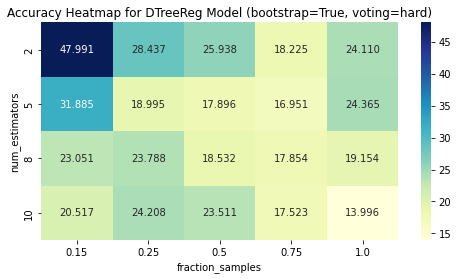

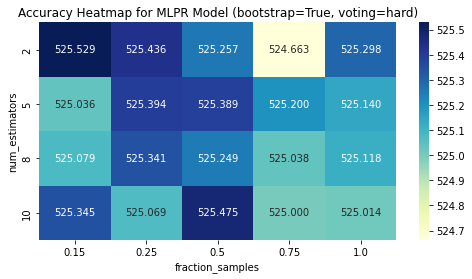

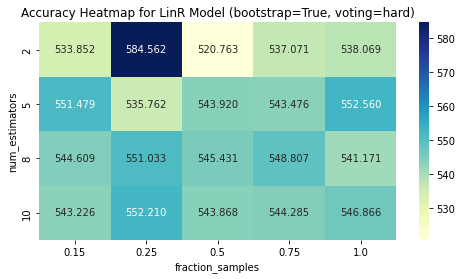

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

models_to_plot = ['DTreeReg', 'MLPR', 'LinR']
conditions = [(True, 'hard')]

for model in models_to_plot:
    for bootstrap, voting in conditions:
        filtered_df = df[(df['model'] == model) & (df['bootstrap'] == bootstrap) & (df['voting'] == voting)]

        # Create a pivot table for the heatmap
        pivot_df = pd.pivot_table(filtered_df, values='mse_loss', index='num_estimators',
                                  columns='fraction_samples', aggfunc='mean')

        # Create the heatmap
        plt.figure(figsize=(8, 4))
        sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f")
        plt.title(f'Accuracy Heatmap for {model} Model (bootstrap={bootstrap}, voting={voting})')
        plt.show()

### Comparision with single weak learner

In [102]:
model1 = LinearRegression(learning_rate=0.001, n_iterations=500)
model2 = DecisionTreeRegression(max_depth=5)
model3 = MLPRegressor(learning_rate=0.3, activation='sigmoid', optimizer='sgd', hidden_layers=[8,4], epochs=1500)

In [103]:
for cnt,model in enumerate([model1,model2,model3]):
    start_time = time.time()
    model.fit(X_train_regression,y_train_regression)
    y_pred = model.predict(X_test_regression)
    mse_loss = np.mean((y_test_regression - y_pred.flatten())**2)

    print(f"For single weak learner model {cnt}: {mse_loss} , training_time : {time.time()-start_time}")

For single weak learner model 0: 547.3972716343186 , training_time : 0.009174108505249023
For single weak learner model 1: 29.09232390140251 , training_time : 0.0023915767669677734
For single weak learner model 2: 524.6856780492552 , training_time : 0.11491751670837402


|          | LinearRegressor | DecisionTreeRegressor | MLPRegressor |
|----------|-----------------|------------------------|-------------|
| Single Models |     547.39            |       29.09                 |      524.68       |
| Bagging Ensembles     |      520.76           |       12.30                 |      524.66       |


#### Best Bagging models (increasing order of MSE loss)
<ol>
<li>Decision Tree Regressor : `12.30`</li>
<li>Linear Regression model : `520.76`</li>
<li>MLP Regression : `524.66`</li>
</ol>

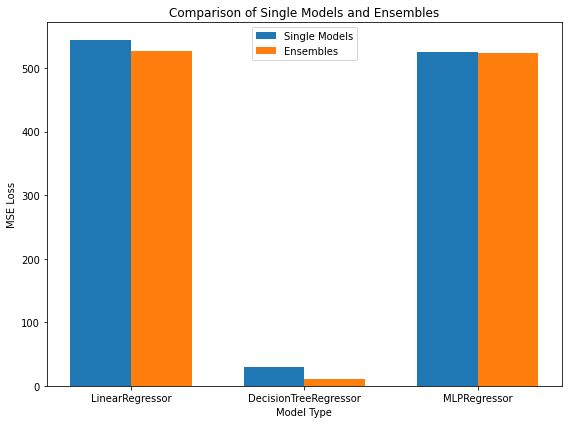

In [104]:
import matplotlib.pyplot as plt

# Accuracy values
accuracy_data = {
    'LinearRegressor': [544.72, 527.55],
    'DecisionTreeRegressor': [29.09, 10.88],
    'MLPRegressor': [525.23, 524.29]
}

# Labels for the x-axis
labels = ['Single Models', 'Ensembles']

# Data for the histograms
single_models = [accuracy_data[model][0] for model in accuracy_data]
ensembles = [accuracy_data[model][1] for model in accuracy_data]

# Create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set the width of the bars
bar_width = 0.35

# Set the positions for the bars
single_models_positions = range(len(accuracy_data))
ensembles_positions = [pos + bar_width for pos in single_models_positions]

# Create the bar plots
plt.bar(single_models_positions, single_models, bar_width, label='Single Models')
plt.bar(ensembles_positions, ensembles, bar_width, label='Ensembles')

# Set labels, ticks, and title
plt.xlabel('Model Type')
plt.ylabel('MSE Loss')
plt.title('Comparison of Single Models and Ensembles')

# Set x-axis labels at the center of each group of bars
ax.set_xticks([pos + bar_width / 2 for pos in single_models_positions])
ax.set_xticklabels(list(accuracy_data.keys()))

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<br>

# Bagging for Classification

In [105]:
import copy

# Bagging
class Bagging:
    def __init__(self, base_model, num_estimators, fraction_samples, bootstrap, voting = 'hard'):
        self.base_model = base_model
        self.num_estimators = num_estimators
        self.fraction_samples = fraction_samples
        self.bootstrap = bootstrap
        self.voting = voting
        self.models = []

    def resample_data(self,X_train, y_train):
        if self.bootstrap:
            num_samples = X_train.shape[0]
            num_resampled_samples = int(self.fraction_samples * num_samples)

            # Generate random indices with replacement
            resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=True)

            # Create resampled datasets based on the selected indices
            X_resampled = X_train[resampled_indices]
            y_resampled = y_train[resampled_indices]

            return X_resampled, y_resampled
        else:
            num_samples = len(X_train)
            num_resampled_samples = int(self.fraction_samples * num_samples)

            # Generate random indices with replacement
            resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=False)

            # Create resampled datasets based on the selected indices
            X_resampled = X_train[resampled_indices]
            y_resampled = y_train[resampled_indices]

            return X_resampled, y_resampled

    def fit(self, X, y):
        for _ in range(self.num_estimators):
            X_sampled, y_sampled = self.resample_data(X, y)
            model = copy.deepcopy(self.base_model)
            model.fit(X_sampled, y_sampled)
            self.models.append(model)

    def predict(self, X):
        # can change depending on output nodes
        
        if self.voting=='soft':
            prediction = np.zeros((X.shape[0],6))
            for model in self.models:
                prediction += model.predict(X)
            return prediction
        else:
            prediction = np.zeros((X.shape[0],6))
            for model in self.models:
                pred = np.argmax(model.predict(X),axis=1)
                row_max_indices = [(i, np.argmax(row)) for i, row in enumerate(pred)]
                prediction[row_max_indices]+=1
            return prediction

In [106]:
model1 = MultinomialLogisticRegression(learning_rate=0.0020,num_epochs=2000)
model2 = DecisionTreeClassificationModel(max_depth=15)
model3 = MLPClassifier(learning_rate=0.1,activation='sigmoid',optimizer='sgd',hidden_layers=[8,6],epochs=100)

### Ensemble learning

In [107]:
from prettytable import PrettyTable
import time
results = []

for cnt,model in enumerate([model1,model2,model3]):
    best_bagging_mse_loss = float('inf')
    set_of_hp = []
    leni = 0
    best_accuracy = 0
    set_of_hp = []
    for num_estimators in [2,5,8,10]:
        for fraction_samples in [0.15,0.25,0.5, 0.75, 1.0]:
            for bootstrap in [True,False]:
                for voting in ['soft','hard']:
                    start_time = time.time()
                    bagging_model = Bagging(base_model=model,num_estimators=num_estimators,fraction_samples=fraction_samples,bootstrap=bootstrap,voting=voting)
                    bagging_model.fit(X_train_classification,y_train_classification)
                    y_pred = bagging_model.predict(X_val_classification)
                    accuracy=np.sum(np.argmax(y_pred,axis=1)==np.argmax(y_val_classification,axis=1))
                         
                    leni = y_pred.shape[0]

                    accuracy = accuracy/leni
                    training_time = time.time()-start_time

                    

                    if cnt==0:
                            results.append({
                            "model" : "LogR",
                            "num_estimators": num_estimators,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "voting": voting,
                            "accuracy" : round(accuracy,3),
                            "training_time":training_time
                            })
                    elif cnt==1:
                            results.append({
                            "model" : "DTree",
                            "num_estimators": num_estimators,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "voting": voting,
                            "accuracy" : round(accuracy,3),
                            "training_time":training_time
                            })
                    else:
                            results.append({
                            "model" : "MLP",
                            "num_estimators": num_estimators,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "voting": voting,
                            "accuracy" : round(accuracy,3),
                            "training_time":training_time
                            })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="accuracy", ascending=False).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["model", "num_estimators", "fraction_samples","bootstrap","voting","accuracy","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["model"], row["num_estimators"], row["fraction_samples"],row["bootstrap"],row["voting"],row["accuracy"],row["training_time"]])

# Print the table with borders and headers
print(table)            
                        

+-------+----------------+------------------+-----------+--------+----------+----------------------+
| model | num_estimators | fraction_samples | bootstrap | voting | accuracy |    training_time     |
+-------+----------------+------------------+-----------+--------+----------+----------------------+
| DTree |       2        |       1.0        |   False   |  soft  |   1.0    | 0.01084280014038086  |
| DTree |       8        |       1.0        |   False   |  soft  |   1.0    | 0.042444705963134766 |
| DTree |       10       |       1.0        |   False   |  soft  |   1.0    | 0.05251145362854004  |
| DTree |       5        |       1.0        |   False   |  soft  |   1.0    | 0.026587247848510742 |
| DTree |       5        |       0.75       |   False   |  soft  |  0.995   | 0.020769357681274414 |
| DTree |       10       |       0.75       |   False   |  soft  |  0.993   | 0.04189610481262207  |
| DTree |       8        |       0.75       |   False   |  soft  |  0.991   | 0.03387904167

In [108]:
df

,model,num_estimators,fraction_samples,bootstrap,voting,accuracy,training_time
0,LogR,2,0.15,True,soft,0.581,1.502992
1,LogR,2,0.15,True,hard,0.005,1.435966
2,LogR,2,0.15,False,soft,0.587,1.407279
3,LogR,2,0.15,False,hard,0.005,1.393317
4,LogR,2,0.25,True,soft,0.585,1.466818
...,...,...,...,...,...,...,...
235,MLP,10,0.75,False,hard,0.005,27.622045
236,MLP,10,1.00,True,soft,0.725,36.622956
237,MLP,10,1.00,True,hard,0.005,36.638975
238,MLP,10,1.00,False,soft,0.673,36.783647


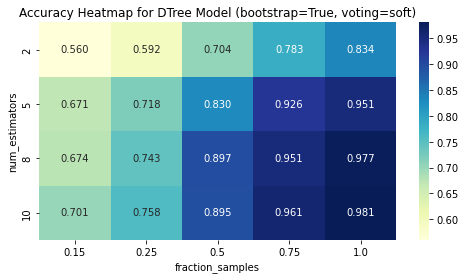

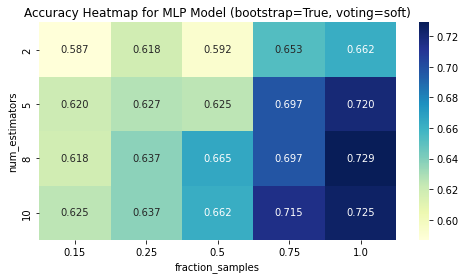

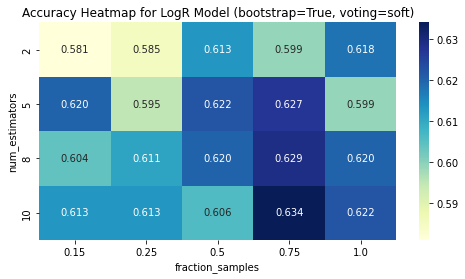

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

models_to_plot = ['DTree', 'MLP', 'LogR']
conditions = [(True, 'soft')]

for model in models_to_plot:
    for bootstrap, voting in conditions:
        filtered_df = df[(df['model'] == model) & (df['bootstrap'] == bootstrap) & (df['voting'] == voting)]

        # Create a pivot table for the heatmap
        pivot_df = pd.pivot_table(filtered_df, values='accuracy', index='num_estimators',
                                  columns='fraction_samples', aggfunc='mean')

        # Create the heatmap
        plt.figure(figsize=(8, 4))
        sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f")
        plt.title(f'Accuracy Heatmap for {model} Model (bootstrap={bootstrap}, voting={voting})')
        plt.show()

In [115]:
model1 = MultinomialLogisticRegression(learning_rate=0.0020,num_epochs=2000)
model2 = DecisionTreeClassificationModel(max_depth=15)
model3 = MLPClassifier(learning_rate=0.1,activation='sigmoid',optimizer='sgd',hidden_layers=[8,6],epochs=100)

In [116]:
# Bagging models on test set


bagging_model = Bagging(base_model=model1,num_estimators=10,fraction_samples=0.75,bootstrap=True,voting='soft')
bagging_model.fit(X_train_classification,y_train_classification)
y_pred = bagging_model.predict(X_test_classification)
accuracy=np.sum(np.argmax(y_pred,axis=1)==np.argmax(y_test_classification,axis=1))
                            
leni = y_pred.shape[0]

accuracy = accuracy/leni

print(f"For model 0,accuracy is : ",accuracy)

bagging_model = Bagging(base_model=model2,num_estimators=10,fraction_samples=1,bootstrap=True,voting='soft')
bagging_model.fit(X_train_classification,y_train_classification)
y_pred = bagging_model.predict(X_test_classification)
accuracy=np.sum(np.argmax(y_pred,axis=1)==np.argmax(y_test_classification,axis=1))
                            
leni = y_pred.shape[0]

accuracy = accuracy/leni

print(f"For model 1,accuracy is : ",accuracy)

bagging_model = Bagging(base_model=model3,num_estimators=8,fraction_samples=1,bootstrap=True,voting='soft')
bagging_model.fit(X_train_classification,y_train_classification)
y_pred = bagging_model.predict(X_test_classification)
accuracy=np.sum(np.argmax(y_pred,axis=1)==np.argmax(y_test_classification,axis=1))
                            
leni = y_pred.shape[0]

accuracy = accuracy/leni

print(f"For model 2,accuracy is : ",accuracy)

For model 0,accuracy is :  0.6223776223776224
For model 1,accuracy is :  0.7674825174825175
For model 2,accuracy is :  0.6643356643356644


In [110]:
model1 = MultinomialLogisticRegression(learning_rate=0.0020,num_epochs=2000)
model2 = DecisionTreeClassificationModel(max_depth=15)
model3 = MLPClassifier(learning_rate=0.1,activation='sigmoid',optimizer='sgd',hidden_layers=[8,6],epochs=100)

In [112]:
for cnt,model in enumerate([model1,model2,model3]):

    start_time = time.time()
    leni = 0
    best_accuracy = 0

    model.fit(X_train_classification,y_train_classification)
    y_pred = model.predict(X_test_classification)
    accuracy=np.sum(np.argmax(y_pred,axis=1)==np.argmax(y_test_classification,axis=1))
                         
    leni = y_pred.shape[0]
    accuracy = accuracy/leni

    if accuracy > best_accuracy:
        best_accuracy = accuracy
    print(f"For model {cnt} , accuracy : {best_accuracy*100}% , time_taken = {time.time()-start_time}")

For model 0 , accuracy : 61.713286713286706% , time_taken = 0.5957880020141602
For model 1 , accuracy : 74.12587412587412% , time_taken = 0.005506992340087891
For model 2 , accuracy : 58.21678321678322% , time_taken = 3.6771576404571533


|          | LogisticRegressor | DecisionTreeClassifier | MLPClassifier |
|----------|-----------------|------------------------|-------------|
| Single Models |     61.71 %           |       74.12 %                  |       58.21 %      |
| Bagging Ensemble     |     62.23 % %            |      76 %                  |     66.40 %        |

#### Hence in comparisions we can see remarkable results in ensemble learning !!!

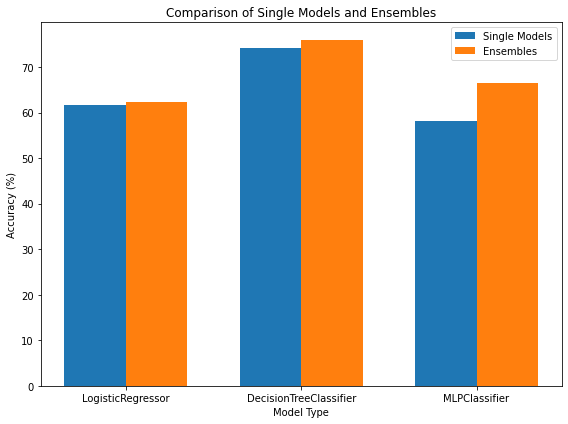

In [117]:
import matplotlib.pyplot as plt

# Accuracy values
accuracy_data = {
    'LogisticRegressor': [61.71, 62.23],
    'DecisionTreeClassifier': [74.12, 76.00],
    'MLPClassifier': [58.21, 66.40]
}

# Labels for the x-axis
labels = ['Single Models', 'Ensembles']

# Data for the histograms
single_models = [accuracy_data[model][0] for model in accuracy_data]
ensembles = [accuracy_data[model][1] for model in accuracy_data]

# Create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set the width of the bars
bar_width = 0.35

# Set the positions for the bars
single_models_positions = range(len(accuracy_data))
ensembles_positions = [pos + bar_width for pos in single_models_positions]

# Create the bar plots
plt.bar(single_models_positions, single_models, bar_width, label='Single Models')
plt.bar(ensembles_positions, ensembles, bar_width, label='Ensembles')

# Set labels, ticks, and title
ax.set_xticks([pos + bar_width / 2 for pos in single_models_positions])
ax.set_xticklabels(list(accuracy_data.keys()))
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Single Models and Ensembles')

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# END

# 3.3

## Stacking for Classification

### Stacking functions

In [174]:
def kfold_training_model(model,X_train,y_train,k):
    start=0
    end = k
    results_for_l1 = []

    shape=0
    while end<=X_train.shape[0]:
        cloned_model = copy.deepcopy(model)
        x_fold_train = np.concatenate((X_train[:start],X_train[end:]),axis=0)
        y_fold_train = np.concatenate((y_train[:start],y_train[end:]),axis=0)

        cloned_model.fit(x_fold_train,y_fold_train)

        x_fold_val = X_train[start:end]
        y_fold_val = y_train[start:end]

        results_for_l1.append(cloned_model.predict(x_fold_val))

        start+=k
        end+=k

        shape+=k
    
    combined_output = np.vstack(results_for_l1) 
    return combined_output,shape

In [175]:
def stacking(level0_models,level1_model,dataset,cv=10):
    X_train,y_train,X_test,y_test = dataset
    k = (y_train.shape[0])//cv
    final_meta_input = np.zeros((X_train.shape[0]-X_train.shape[0]%k,y_train.shape[1]*len(level0_models)))

    for index,model in enumerate(level0_models):
        output_for_base,sh = kfold_training_model(model,X_train,y_train,k=k)
        final_meta_input[:,index*y_train.shape[1]:(index+1)*y_train.shape[1]] = output_for_base
    
    # train the meta model
    level1_model.fit(final_meta_input,y_train[:sh])

    return level1_model,sh

In [176]:
def prediction_stacked_model(level0_models,trained_meta_model,dataset):
    X_train,y_train,X_test,y_test = dataset
    final_meta_input = np.zeros((X_test.shape[0],y_test.shape[1]*len(level0_models)))

    cloned_model_list = []
    for model in level0_models:
        cloned_model = copy.deepcopy(model)
        cloned_model.fit(X_train,y_train)
        cloned_model_list.append(cloned_model)

    for index,model in enumerate(cloned_model_list):
        final_meta_input[:,index*y_test.shape[1]:(index+1)*y_test.shape[1]] = model.predict(X_test)
    
    return trained_meta_model.predict(final_meta_input)

### Blending functions

In [177]:
def blending(level0_models,level1_model,dataset,cv=10):
    X_train,y_train,X_test,y_test = dataset
    k = (y_train.shape[0])//cv

    # forms a different validation set

    X_train_base,X_val_meta,y_train_base,y_val_meta = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

    final_meta_input = np.zeros((X_val_meta.shape[0],y_val_meta.shape[1]*len(level0_models)))

    for index,model in enumerate(level0_models):
        clone_model = copy.deepcopy(model)
        clone_model.fit(X_train_base,y_train_base)
        output_for_base = clone_model.predict(X_val_meta)
        final_meta_input[:,index*y_val_meta.shape[1]:(index+1)*y_val_meta.shape[1]] = output_for_base
    
    # train the meta model
    level1_model.fit(final_meta_input,y_val_meta)

    return level1_model

In [178]:
model1 = MultinomialLogisticRegression(learning_rate=0.0020,num_epochs=2000)
model2 = DecisionTreeClassificationModel(max_depth=15)
model3 = MLPClassifier(learning_rate=0.1,activation='sigmoid',optimizer='sgd',hidden_layers=[8,6],epochs=100)

In [179]:
level0_models = [model1,model2,model3]
l1_model1 = MultinomialLogisticRegression(learning_rate=0.0020,features=y_train_classification.shape[1]*3,output_labels=6,num_epochs=500)
l1_model2 = DecisionTreeClassificationModel(max_depth=15)

for option in ['stacking','blending']:
    for cnt,level1_model in enumerate([l1_model1,l1_model2]):

        start_time = time.time()
        if option=='stacking':
            trained_l1_model,sh = stacking(level0_models=level0_models,level1_model=copy.deepcopy(level1_model),dataset=(X_train_classification,y_train_classification,X_val_classification,y_val_classification))            
        else:
            trained_l1_model = blending(level0_models=level0_models,level1_model=copy.deepcopy(level1_model),dataset=(X_train_classification,y_train_classification,X_val_classification,y_val_classification))

        y_pred = prediction_stacked_model(level0_models=level0_models,trained_meta_model=copy.deepcopy(trained_l1_model),dataset=(X_train_classification,y_train_classification,X_test_classification,y_test_classification))
        
        accuracy=np.mean(np.argmax(y_pred,axis=1)==np.argmax(y_test_classification,axis=1))
        if cnt==0:
            print(f"For model {option} and metamodel LogisticReg, val Accuracy = {accuracy} , time_taken = {time.time()-start_time}")
        else:
            print(f"For model {option} and metamodel DecisionTreeCls,val Accuracy = {accuracy} , time_taken = {time.time()-start_time}")

For model stacking and metamodel LogisticReg, val Accuracy = 0.6713286713286714 , time_taken = 63.49007606506348
For model stacking and metamodel DecisionTreeCls,val Accuracy = 0.5944055944055944 , time_taken = 63.47988700866699
For model blending and metamodel LogisticReg, val Accuracy = 0.6730769230769231 , time_taken = 11.818790197372437
For model blending and metamodel DecisionTreeCls,val Accuracy = 0.4825174825174825 , time_taken = 11.84357762336731


|          | LogisticRegressor | DecisionTreeClassifier 
|----------|-----------------|------------------------|
| Stacking |     67.13 %           |       59.44 %                 |    
| Blending     |     67 %            |      48.25 %                  | 

#### Best Model is Logistic Regression as meta model with stacking , Accuracy = 67.13 % 

## Stacking for Regression

In [180]:
import copy

### Stacking Function

In [181]:
def kfold_training_model(model,X_train,y_train,k):
    start=0
    end = k
    results_for_l1 = []

    shape=0
    while end<=X_train.shape[0]:
        cloned_model = copy.deepcopy(model)
        x_fold_train = np.concatenate((X_train[:start],X_train[end:]),axis=0)
        y_fold_train = np.concatenate((y_train[:start],y_train[end:]),axis=0)

        cloned_model.fit(x_fold_train,y_fold_train)

        x_fold_val = X_train[start:end]
        y_fold_val = y_train[start:end]

        results_for_l1.append(cloned_model.predict(x_fold_val).reshape((-1,1)))

        start+=k
        end+=k

        shape+=k
    
    combined_output = np.vstack(results_for_l1) 
    return combined_output,shape

In [182]:
def stacking(level0_models,level1_model,dataset,cv=10):
    X_train,y_train,X_test,y_test = dataset
    k = (y_train.shape[0])//cv

    final_meta_input = np.zeros((X_train.shape[0]-X_train.shape[0]%k,len(level0_models)))

    for index,model in enumerate(level0_models):
        output_for_base,sh = kfold_training_model(model,X_train,y_train,k=k)
        final_meta_input[:,index:(index+1)] = output_for_base
    
    # train the meta model
    level1_model.fit(final_meta_input,y_train[:sh])

    return level1_model,sh

In [183]:
def prediction_stacked_model(level0_models,trained_meta_model,dataset):
    X_train,y_train,X_test,y_test = dataset
    final_meta_input = np.zeros((X_test.shape[0],len(level0_models)))

    cloned_model_list = []
    for model in level0_models:
        cloned_model = copy.deepcopy(model)
        cloned_model.fit(X_train,y_train)
        cloned_model_list.append(cloned_model)

    for index,model in enumerate(cloned_model_list):
        final_meta_input[:,index:(index+1)] = model.predict(X_test).reshape((-1,1))
    
    return trained_meta_model.predict(final_meta_input).reshape((-1,1))

### Blending functions

In [184]:
def blending(level0_models,level1_model,dataset,cv=10):
    X_train,y_train,X_test,y_test = dataset
    k = (y_train.shape[0])//cv

    # forms a different validation set

    X_train_base,X_val_meta,y_train_base,y_val_meta = train_test_split(
    X_train, y_train, test_size=0.40, random_state=42)

    final_meta_input = np.zeros((X_val_meta.shape[0],len(level0_models)))

    for index,model in enumerate(level0_models):
        clone_model = copy.deepcopy(model)
        clone_model.fit(X_train_base,y_train_base)
        output_for_base = clone_model.predict(X_val_meta).reshape((-1,1))
        final_meta_input[:,index:(index+1)] = output_for_base
    
    # train the meta model
    level1_model.fit(final_meta_input,y_val_meta)

    return level1_model

In [185]:
model1 = LinearRegression(learning_rate=0.001, n_iterations=2000)
model2 = DecisionTreeRegression(max_depth=5)
model3 = MLPRegressor(learning_rate=0.3, activation='sigmoid', optimizer='sgd', hidden_layers=[8,4], epochs=1500)

In [186]:
level0_models = [model1,model2,model3]
l1_model1 = LinearRegression(learning_rate=0.001, n_iterations=2000)
l1_model2 = DecisionTreeRegression(max_depth=5)

for option in ['stacking','blending']:
    for cnt,level1_model in enumerate([l1_model1,l1_model2]):

        start_time = time.time()
        if option=='stacking':
            trained_l1_model,sh = stacking(level0_models=level0_models,level1_model=copy.deepcopy(level1_model),dataset=(X_train_regression,y_train_regression,X_val_regression,y_val_regression))            
        else:
            trained_l1_model = blending(level0_models=level0_models,level1_model=copy.deepcopy(level1_model),dataset=(X_train_regression,y_train_regression,X_val_regression,y_val_regression))

        y_pred = prediction_stacked_model(level0_models=level0_models,trained_meta_model=copy.deepcopy(trained_l1_model),dataset=(X_train_regression,y_train_regression,X_test_regression,y_test_regression))
        
        mse_loss = np.mean((y_pred.flatten()-y_test_regression)**2)
        if cnt==0:
            print(f"For model {option} and metamodel LogisticReg, mse_loss = {mse_loss} , time_taken = {time.time()-start_time}")
        else:
            print(f"For model {option} and metamodel DecisionTreeCls, mse_loss = {mse_loss} , time_taken = {time.time()-start_time}")
            

For model stacking and metamodel LogisticReg, mse_loss = 28.59525212475345 , time_taken = 1.4017808437347412
For model stacking and metamodel DecisionTreeCls, mse_loss = 26.120451787989293 , time_taken = 1.3681700229644775
For model blending and metamodel LogisticReg, mse_loss = 30.318946563322744 , time_taken = 0.24186038970947266
For model blending and metamodel DecisionTreeCls, mse_loss = 28.450931249999993 , time_taken = 0.2354879379272461


## Comparing the accuracies of Bagging and Stacking ensemble best models vs Training Time

## Classification

#### Accuracies

|          | LogisticRegressor | DecisionTreeClassifier | MLPClassifier |
|----------|-----------------|------------------------|-------------|
| Single Models |     61.71 %           |       74.12 %                  |       58.21 %      |
| Bagging Ensemble     |     62.23 % %            |      76 %                  |     66.40 %        |
| Stacking |     67.13 %           |       59.44 %                 |  Nil  |
| Blending     |     67 %            |      48.25 %                  | Nil |

#### Training Time

|          | LogisticRegressor | DecisionTreeClassifier | MLPClassifier | 
|----------|-----------------|------------------------|-------------|
| Single Models |  0.14 s             |      0.005 s                |      3.179 s    |     
| Bagging Ensemble     |       0.235 s         |       0.0289 s               |     20.20 s       |
| Stacking |      48 s       |       45.30 s              |     Nil    |
| Blending     |      8.31 s       |        7.91 s             |  Nil  |

<br>

## Regression

#### Accuracies

|          | LinearRegressor | DecisionTreeRegressor | MLPRegressor |
|----------|-----------------|------------------------|-------------|
| Single Models |     547.39            |       29.09                 |      524.68       |
| Bagging Ensembles     |      520.76           |       12.30                 |      524.66       |
| Stacking |     28.59           |       26.12                 |  Nil  |
| Blending     |     30.31           |      28.45                  | Nil |

#### Training Time

|          | LogisticRegressor | DecisionTreeClassifier | MLPClassifier | 
|----------|-----------------|------------------------|-------------|
| Single Models |  0.0040 s             |      0.0017 s                |      0.0635 s    |     
| Bagging Ensemble     |       0.022470 s         |       0.006243 s               |     0.108201 s       |
| Stacking |      0.8019 s       |       0.801 s              |     Nil    |
| Blending     |      0.1489 s       |        0.147 s             |  Nil  |

# END